In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_statistics import *
from f_preprocessing import *

In [4]:
fol='/home/vanoorschot/work/fransje'

In [5]:
#select index of lat lon points
def select_point(fc,lat_min,lat_max,lon_min,lon_max):
    lat = fc.lat.values
    lon = fc.lon.values
    lat_ix = np.where((lat>lat_min) & (lat<lat_max))[0][0]
    lon_ix = np.where((lon>lon_min) & (lon<lon_max))[0][0]
    latstr = str(np.round(fc.lat[lat_ix].values,3))
    lonstr = str(np.round(fc.lon[lon_ix].values,3)) 
    return lat_ix,lon_ix,latstr,lonstr

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)
colors =['gainsboro','none']
cmap_grey2 = LinearSegmentedColormap.from_list('cm',colors, N=2)
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)

In [7]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [8]:
cmap = cm.get_cmap('RdBu', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu = ListedColormap(color_list)

In [9]:
tl_0_1 = ['0.0','','0.2','','0.4','','0.6','','0.8','','1.0']
tl_02 = ['-0.20','','-0.12','','-0.04','','0.04','','0.12','','0.20']
tl_06 = ['-0.60','','-0.36','','-0.12','','0.12','','0.36','','0.60']
tl_1 = ['-1.0','','-0.6','','-0.2','','0.2','','0.6','','1.0']
tl_01 = ['-0.10','','-0.06','','-0.02','','0.02','','0.06','','0.10']
tl_800=['0','','160','','320','','480','','640','','800']
tl_500=['0','','100','','200','','300','','400','','500']
tl_1500=['0','','300','','600','','900','','1200','','1500']
tl_05=['0.0','','0.1','','0.2','','0.3','','0.4','','0.5']
tl_005=['-0.05','','-0.03','','-0.01','','0.01','','0.03','','0.05']
tl_003=['-0.03','','-0.0015','','0.0','','0.0015','','0.03']
tl_006=['0.0','','0.012','','0.024','','0.036','','0.048','','0.06']

In [10]:
f_mod = f'{fol}/htessel_output/exp5'
mod = xr.open_dataset(f'{f_mod}/monthly_climatology/o_veg_1999_2018_climatology.nc')
m = mod.var66.mean(dim='time')
mn = m.notnull()

## LAI

In [11]:
exp_name1, exp_name2 = 'ex10','exp5'
name1,name2 = 'IALC','IAK5'
start_year = '1999'
end_year = '2018'
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

### mean LAI

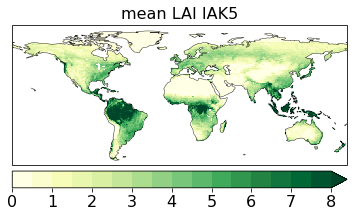

In [12]:
f_mod1 = f'{fol}/htessel_output/{exp_name2}'
start_year=1999
end_year=2019

veg = xr.open_dataset(f'{f_mod1}/monthly/o_veg_{start_year}_{end_year}_monthly.nc')
lail = veg.var66
laih = veg.var67
lai = lail + laih
lm = lail.mean(dim='time')
hm = laih.mean(dim='time')
tm = lai.mean(dim='time')
ls = lail.std(dim='time')
hs = laih.std(dim='time')
ts = lai.std(dim='time')

cmap = plt.cm.get_cmap('YlGn') 
lvls = np.linspace(0,8,17)
lvls2 = np.linspace(0,8,9)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf = tm.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',extend='max',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
ax.set_title(f'mean LAI {name2}',size=16)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/lai/mean_lai_allmonths_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')


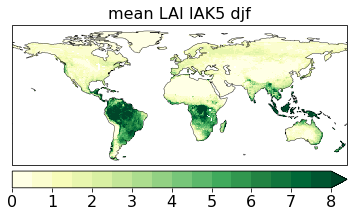

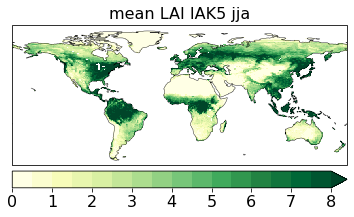

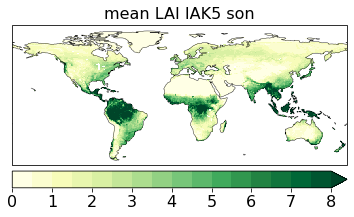

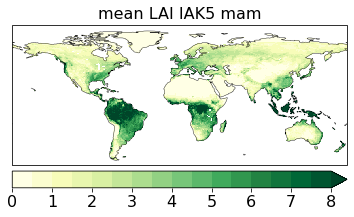

In [13]:
for season in ['djf','jja','son','mam']:
    f_mod1 = f'{fol}/htessel_output/{exp_name2}'
    veg = xr.open_dataset(f'{f_mod1}/seasonal/o_veg_{start_year}_{end_year}_{season}.nc')
    lail = veg.var66
    laih = veg.var67
    lai = lail + laih
    lm = lail.mean(dim='time')
    hm = laih.mean(dim='time')
    tm = lai.mean(dim='time')
    ls = lail.std(dim='time')
    hs = laih.std(dim='time')
    ts = lai.std(dim='time')

    # LAI plot mean values
    cmap = plt.cm.get_cmap('YlGn') 
    lvls = np.linspace(0,8,17)
    lvls2 = np.linspace(0,8,9)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf = tm.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',extend='max',label=f'', pad=0.02, ticks=lvls2)
    cbar.ax.tick_params(labelsize=16)
    ax.set_title(f'mean LAI {name2} {season}',size=16)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/lai/seasons/mean_lai_{season}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

### std LAI anomalies

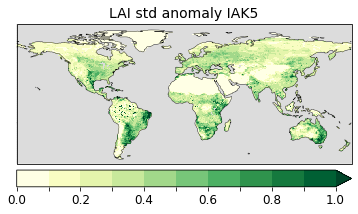

In [12]:
# LAI STD ia anomalies
f_mod1 = f'{fol}/htessel_output/{exp_name2}'

# ANNUAL
veg = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
lail2 = veg.var66
laih2 = veg.var67
lai2 = lail2 + laih2
sl = lail2.std(dim='time')
sh = laih2.std(dim='time')
st = lai2.std(dim='time')

cmapy = plt.cm.get_cmap('YlGn')
n = st.notnull()
lvls= np.linspace(0,1,11)
lvls2= np.linspace(0,1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = st.plot(ax=ax, cmap=cmapy, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'LAI std anomaly {name2}',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/lai/std_anomaly_lai_allmonths_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

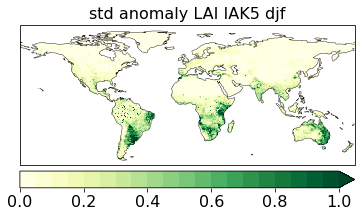

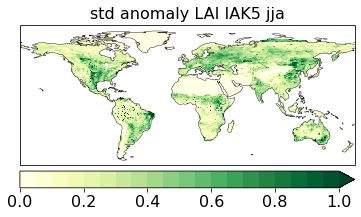

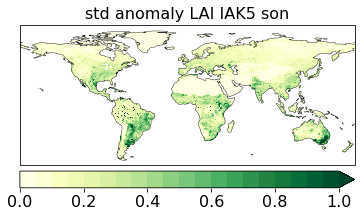

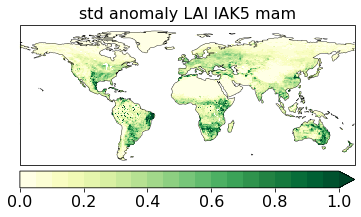

In [17]:
for season in ['djf','jja','son','mam']:
    f_mod1 = f'{fol}/htessel_output/{exp_name2}'
    veg = xr.open_dataset(f'{f_mod1}/seasonal/o_veg_{start_year}_{end_year}_{season}_anomalies.nc')
    lail2 = veg.var66
    laih2 = veg.var67
    lai2 = lail2 + laih2
    sl = lail2.std(dim='time')
    sh = laih2.std(dim='time')
    st = lai2.std(dim='time')

    cmap = plt.cm.get_cmap('YlGn') 
    lvls = np.linspace(0,1,21)
    lvls2 = np.linspace(0,1,6)

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf = st.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',extend='max',label=f'', pad=0.02, ticks=lvls2)
    cbar.ax.tick_params(labelsize=16)
    ax.set_title(f'std anomaly LAI {name2} {season}',size=16)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/lai/seasons/std_anomaly_lai_{season}_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

## EFFECTS ON MEANS

In [18]:
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'
mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_wat_{start_year}_{end_year}_monthly.nc')

et1 = mod1.TVEG * -1000
es1 = mod1.ESOIL * -1000
e1 = mod1.E * -1000
ei1 = mod1.evatc * -1000

et2 = mod2.TVEG * -1000
es2 = mod2.ESOIL * -1000
e2 = mod2.E * -1000
ei2 = mod2.evatc * -1000

etm1 = et1.mean(dim='time')*365
esm1 = es1.mean(dim='time')*365
eim1 = ei1.mean(dim='time')*365
em1 = e1.mean(dim='time')*365

etm2 = et2.mean(dim='time')*365
esm2 = es2.mean(dim='time')*365
eim2 = ei2.mean(dim='time')*365
em2 = e2.mean(dim='time')*365

etm1 = etm1.where(etm1>0.1)
esm1 = esm1.where(esm1>0.1)
eim1 = eim1.where(eim1>0.1)
em1 = em1.where(em1>0.1)

etmask = etm1.where(etm1>0.1)
esmask = esm1.where(esm1>0.1)
eimask = eim1.where(eim1>0.1)
emask = em1.where(em1>0.1)

et_c = (etm2-etm1)/etm1
es_c = (esm2-esm1)/esm1
ei_c = (eim2-eim1)/eim1
e_c = (em2-em1)/em1

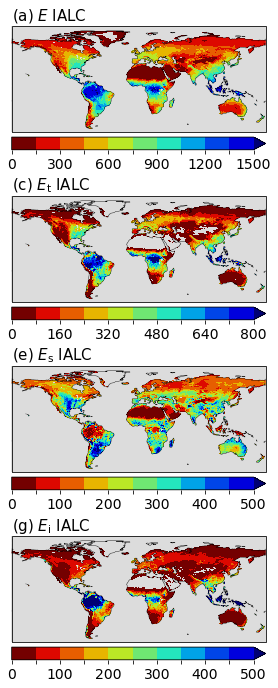

In [19]:
# PLOT MEAN EVAPORATION FLUXES

cmap = cmap_map(lambda x: x/1.1, cm.jet_r)
# cm = plt.cm.get_cmap('jet_r')

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(a) $E$ '+str(name1),size=15, loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,800,11)
lvls2= np.linspace(0,800,11)
n = etm1.notnull()
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = etm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(c) $E_{\mathrm{t}}$ '+str(name1),size=15,loc='left')
cbar.ax.set_xticklabels(tl_800)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = esm1.notnull()
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = esm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(e) $E_{\mathrm{s}}$ '+str(name1),size=15,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = eim1.notnull()
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eim1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(g) $E_{\mathrm{i}}$ '+str(name1),size=15,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/evaporation/e_mean_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

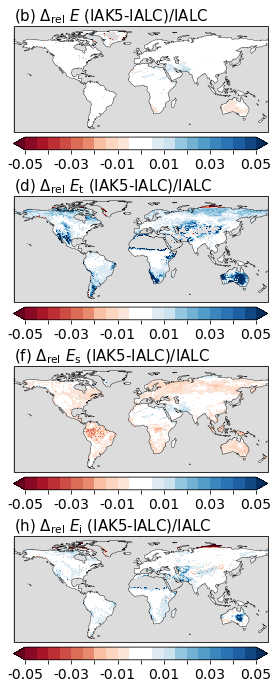

In [20]:
# cmap = plt.cm.get_cmap('RdYlBu')
lvls= np.linspace(-0.2,0.2,21)
lvls2= np.linspace(-0.2,0.2,11)
rel=f'({name2}-{name1})/{name1}'
ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{sb}}$ '+str(rel),size=20,loc='left')

fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = e_c.notnull()
e_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = e_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $E$ '+str(rel),size=15,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = et_c.notnull()
et_c[0,0]=0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = et_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{t}}$ '+str(rel),size=15,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = es_c.notnull()
es_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = es_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(f) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{s}}$ '+str(rel),size=15,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ei_c[0,0]=0.21
n = ei_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ei_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(h) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{i}}$ '+str(rel),size=15,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/evaporation/e_mean_{start_year}_{end_year}_reldiff_{exp_name2}-{exp_name1}_{name2}-{name1}.jpg',dpi=300,bbox_inches='tight')

## EFFECTS ON ANOMALIES

### EVAPORATION

In [21]:
exp_name1, exp_name2 = 'ex10','exp5'
name1,name2 = 'IALC','IAK5'
start_year = '1999'
end_year = '2018'
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'
rel=f'({name2}-{name1})/{name1}'

In [22]:
mod = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time std
ets1 = et.std(dim='time')
ess1 = es.std(dim='time')
eis1 = ei.std(dim='time')
es1 = e.std(dim='time')

ets1 = ets1.where(etmask>0.1)
ess1 = ess1.where(esmask>0.1)
eis1 = eis1.where(eimask>0.1)
es1 = es1.where(emask>0.1)

mod = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
et = mod.TVEG * -1000
es = mod.ESOIL * -1000
e = mod.E * -1000
ei = mod.evatc * -1000

# time std
ets2 = et.std(dim='time')
ess2 = es.std(dim='time')
eis2 = ei.std(dim='time')
es2 = e.std(dim='time')

ets2 = ets2.where(etmask>0.1)
ess2 = ess2.where(esmask>0.1)
eis2 = eis2.where(eimask>0.1)
es2 = es2.where(emask>0.1)

# diff
etsdr = (ets2-ets1)/ets1
essdr = (ess2-ess1)/ess1
eisdr = (eis2-eis1)/eis1
esdr = (es2-es1)/es1

etsd = (ets2-ets1)
essd = (ess2-ess1)
eisd = (eis2-eis1)
esd = (es2-es1)

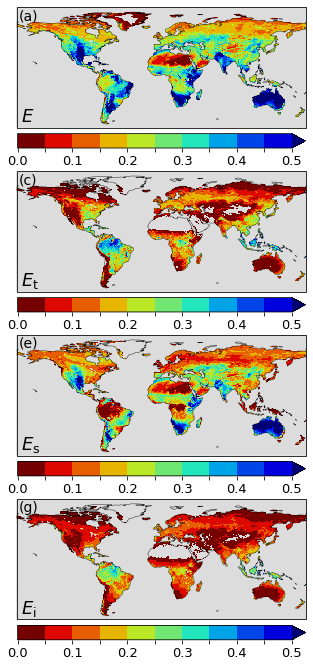

In [23]:
#V2
cmap = cmap_map(lambda x: x/1.1, cm.jet_r)
# cm = plt.cm.get_cmap('jet_r')

lvls= np.linspace(0,0.5,11)
lvls2= np.linspace(0,0.5,11)
fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = es1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = es1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(a) $E$ '+str(name1),size=16, loc='left')
cbar.ax.set_xticklabels(tl_05)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

n = ets1.notnull()
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ets1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(c) $E_{\mathrm{t}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_05)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

n = ess1.notnull()
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ess1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.annotate('(e)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(e) $E_{\mathrm{s}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_05)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

n = eis1.notnull()
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eis1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.annotate('(g)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(g) $E_{\mathrm{i}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_05)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/evaporation/e_std_{start_year}_{end_year}_{exp_name1}_{name1}_v2.jpg',dpi=300,bbox_inches='tight')

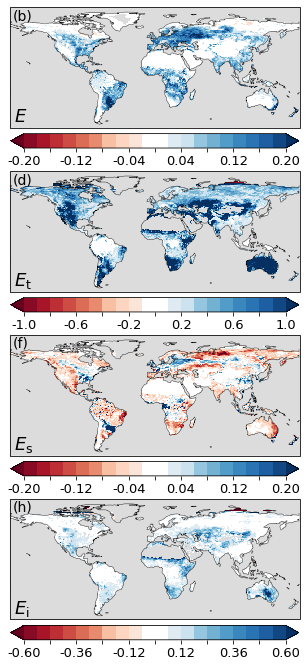

In [24]:
# V2
# plot relative difference E IAKV vs IAK5

# cmap = plt.cm.get_cmap('RdYlBu')


lvls= np.linspace(-0.2,0.2,21)
lvls2= np.linspace(-0.2,0.2,11)
fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = esdr.notnull()
esdr[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = esdr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_02)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $E$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)


lvls= np.linspace(-1,1,21)
lvls2= np.linspace(-1,1,11)
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
etsdr[0,0]=-1.1
n = etsdr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = etsdr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_1)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{t}}$  '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(-0.2,0.2,21)
lvls2= np.linspace(-0.2,0.2,11)
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = essdr.notnull()
essdr[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = essdr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_02)
ax.annotate('(f)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(f) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{s}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(-0.6,0.6,21)
lvls2= np.linspace(-0.6,0.6,11)
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = eisdr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eisdr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_06)
ax.annotate('(h)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(h) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{i}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/evaporation/e_anomaly_std_{start_year}_{end_year}_reldiff_{exp_name2}-{exp_name1}_{name2}-{name1}_v2.jpg',dpi=300,bbox_inches='tight')

### SOIL MOISTURE - all months

In [25]:
f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'
mod1 = xr.open_dataset(f'{f_mod1}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/monthly/o_soil_{start_year}_{end_year}_monthly.nc')
name1='IAK5'
name2='IAKV'

sm11 = mod1.SWVL1 
sm12 = mod1.SWVL2 
sm13 = mod1.SWVL3 
sm14 = mod1.SWVL4 
# sm1234 = mod1.SWVL234

sm21 = mod2.SWVL1
sm22 = mod2.SWVL2
sm23 = mod2.SWVL3
sm24 = mod2.SWVL4
# sm2234 = mod2.SWVL234

sm11m = sm11.mean(dim='time')
sm12m = sm12.mean(dim='time')
sm13m = sm13.mean(dim='time')
sm14m = sm14.mean(dim='time')
# sm1234m = sm1234.mean(dim='time')

sm11m = sm11m.where(sm11m>0.01)
sm12m = sm12m.where(sm12m>0.01)
sm13m = sm13m.where(sm13m>0.01)
sm14m = sm14m.where(sm14m>0.01)
# sm1234m = sm1234m.where(sm1234m>0.01)

sm1mask = sm11m.where(sm11m>0.01)
sm2mask = sm12m.where(sm12m>0.01)
sm3mask = sm13m.where(sm13m>0.01)
sm4mask = sm14m.where(sm14m>0.01)
# sm234mask = sm1234m.where(sm1234m>0.01)

sm1_c = (sm21.mean(dim='time')-sm11m)/sm11m
sm2_c = (sm22.mean(dim='time')-sm12m)/sm12m
sm3_c = (sm23.mean(dim='time')-sm13m)/sm13m
sm4_c = (sm24.mean(dim='time')-sm14m)/sm14m
# sm234_c = (sm2234.mean(dim='time')-sm1234m)/sm1234m

In [26]:
# load anomalies of soil moisture
mod = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm1 = mod.SWVL1 
sm2 = mod.SWVL2 
sm3 = mod.SWVL3 
sm4  = mod.SWVL4 
sm234 = mod.SWVL234

# time std
sms11 = sm1.std(dim='time')
sms21 = sm2.std(dim='time')
sms31 = sm3.std(dim='time')
sms41 = sm4.std(dim='time')
sms2341 = sm234.std(dim='time')

sms11 = sms11.where(sm1mask>0.01)
sms21 = sms21.where(sm2mask>0.01)
sms31 = sms31.where(sm3mask>0.01)
sms41 = sms41.where(sm4mask>0.01)
# sms2341 = sms2341.where(sm234mask>0.01)
sms2341 = sms2341.where(sm2mask>0.01)

mod = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm1 = mod.SWVL1 
sm2 = mod.SWVL2 
sm3 = mod.SWVL3 
sm4  = mod.SWVL4 
sm234 = mod.SWVL234

# time std
sms12 = sm1.std(dim='time')
sms22 = sm2.std(dim='time')
sms32 = sm3.std(dim='time')
sms42 = sm4.std(dim='time')
sms2342 = sm234.std(dim='time')

sms12 = sms12.where(sm1mask>0.01)
sms22 = sms22.where(sm2mask>0.01)
sms32 = sms32.where(sm3mask>0.01)
sms42 = sms42.where(sm4mask>0.01)
# sms2342 = sms2342.where(sm234mask>0.01)
sms2342 = sms2342.where(sm2mask>0.01)

# diff
sms1d = sms12 -sms11
sms2d = sms22 -sms21
sms3d = sms32 -sms31
sms4d = sms42 -sms41

# reldiff
sms1dr = (sms12 -sms11)/sms11
sms2dr = (sms22 -sms21)/sms21
sms3dr = (sms32 -sms31)/sms31
sms4dr = (sms42 -sms41)/sms41
sms234dr = (sms2342 -sms2341)/sms2341

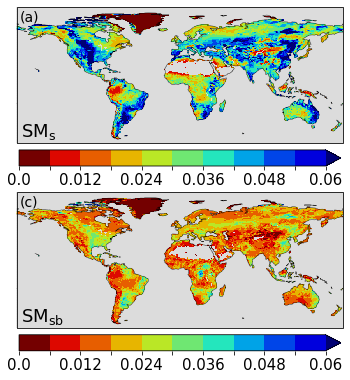

In [27]:
# V2
cmap = cmap_map(lambda x: x/1.1, cm.jet_r)
lvls= np.linspace(0,0.06,11)
lvls2= np.linspace(0,0.06,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sms1dr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sms11.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_006)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(a) $\mathrm{SM}_{\mathrm{s}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sms2dr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sms2341.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_006)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(c) $\mathrm{SM}_{\mathrm{sb}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/soil_moisture/sm_2_std_relsm_{start_year}_{end_year}_{exp_name1}_{name1}_v2.jpg',dpi=300,bbox_inches='tight')

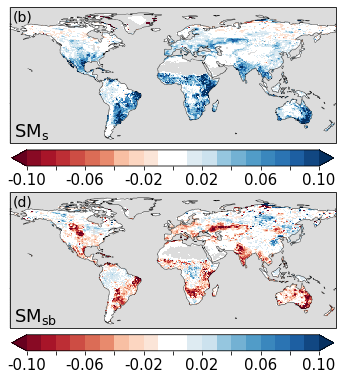

In [28]:
#v2
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sms1dr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sms1dr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_01)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{s}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sms2dr.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sms234dr.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_01)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{sb}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/soil_moisture/sm_2_std_reldiff_{start_year}_{end_year}_{exp_name2}-{exp_name1}_{name2}-{name1}_v2.jpg',dpi=300,bbox_inches='tight')

### COVARIANCE

In [29]:
mod = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod.SWVL1 
sm12 = mod.SWVL2 
sm13 = mod.SWVL3 
sm14  = mod.SWVL4 
sm1234 = mod.SWVL234

mod = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm21 = mod.SWVL1 
sm22 = mod.SWVL2 
sm23 = mod.SWVL3 
sm24  = mod.SWVL4 
sm2234 = mod.SWVL234

mod = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
et1 = mod.TVEG * -1000
es1 = mod.ESOIL * -1000
e1= mod.E * -1000
ei1 = mod.evatc * -1000

mod = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
et2 = mod.TVEG * -1000
es2 = mod.ESOIL * -1000
e2 = mod.E * -1000
ei2 = mod.evatc * -1000

mod = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
lail1 = mod.var66
laih1 = mod.var67
lai1 = lail1+laih1

mod = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
lail2 = mod.var66
laih2 = mod.var67
lai2 = lail2+laih2

In [30]:
c_et_1 = xr.cov(et1,sm13,dim='time')
c_et_2 = xr.cov(et2,sm23,dim='time')

c_es_1 = xr.cov(es1,sm11,dim='time')
c_es_2 = xr.cov(es2,sm21,dim='time')

c_sms_1 = xr.cov(lai1,sm11,dim='time')
c_smsb_1 = xr.cov(lai1,sm1234,dim='time')

c_sms_2 = xr.cov(lai2,sm21,dim='time')
c_smsb_2 = xr.cov(lai2,sm2234,dim='time')

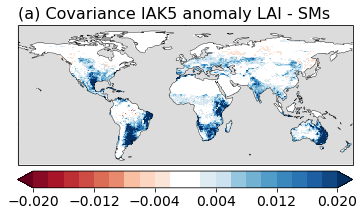

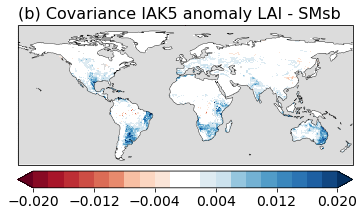

In [31]:
lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,6)
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
c_sms_2[0,0]=-0.021
n = c_sms_2.notnull()
cf2 = n.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cf = c_sms_2.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
ax.set_title(f'(a) Covariance IAK5 anomaly LAI - SMs',size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/cov_IAK5_sms_lai_anomaly.jpg',dpi=300,bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
c_smsb_2[0,0]=-0.021
n = c_sms_2.notnull()
cf2 = n.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cf = c_smsb_2.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
ax.set_title(f'(b) Covariance IAK5 anomaly LAI - SMsb',size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/scripts/HTESSEL/figures/paper_figures/{exp_name1}_{exp_name2}/global_maps/cov_IAK5_smsb_lai_anomaly.jpg',dpi=300,bbox_inches='tight')